# Money Laundering Prevention


In [1]:
'''importing the required libraries'''

import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [2]:
'''Importing the dataset and checking its properties '''

df= pd.read_csv('data.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# EDA

In [4]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

## Checking for any null values

In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Check Data

In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [8]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [9]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

Text(0, 0.5, 'Count of transaction')

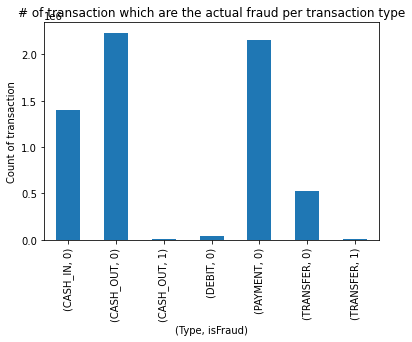

In [10]:
ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")

We find that of the five types of transactions, fraud occurs only in two of them: 'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash. Remarkably, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs

In [11]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer)))

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout)))


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


In [12]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            # only 'TRANSFER'

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) # 353874.22

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max()))


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


# Data cleaning

we know that fraud only occurs in 'TRANSFER's and 'CASH_OUT's. So we assemble only the corresponding data in x for analysis.

In [13]:
x = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

In [14]:
x.shape

(2770409, 11)

## Remove Unwanted Features

In [15]:
x.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
x = x.reset_index(drop=True)

C:\Users\Vaishali\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Dealing with Categorical Feature

In [16]:
x.loc[x.type == 'TRANSFER', 'type'] = 0
x.loc[x.type == 'CASH_OUT', 'type'] = 1
x.type = x.type.astype(int) # convert dtype('O') to dtype(int)

In [17]:
x

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,0,181.00,181.00,0.0,0.00,0.00,1
1,1,181.00,181.00,0.0,21182.00,0.00,1
2,1,229133.94,15325.00,0.0,5083.00,51513.44,0
3,0,215310.30,705.00,0.0,22425.00,0.00,0
4,0,311685.89,10835.00,0.0,6267.00,2719172.89,0
...,...,...,...,...,...,...,...
2770404,1,339682.13,339682.13,0.0,0.00,339682.13,1
2770405,0,6311409.28,6311409.28,0.0,0.00,0.00,1
2770406,1,6311409.28,6311409.28,0.0,68488.84,6379898.11,1
2770407,0,850002.52,850002.52,0.0,0.00,0.00,1


Creating 2 new features (columns) recording errors in the originating and destination accounts for each transaction.

In [18]:
x['errorbalanceOrg'] = x.newbalanceOrig + x.amount - x.oldbalanceOrg
x['errorbalanceDest'] = x.oldbalanceDest + x.amount - x.newbalanceDest

## Plot correlation matrix to check multicolinearity between variables 

<AxesSubplot:>

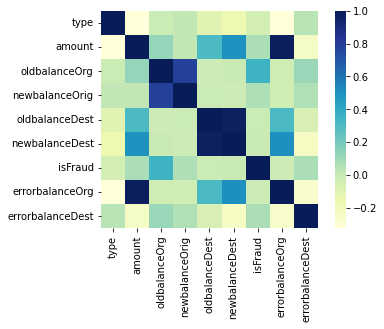

In [19]:
correlation=x.corr()
sns.heatmap(correlation, vmax=1, square=True,cmap="YlGnBu")

In [20]:
X=x.drop(['isFraud'],axis=1)
Y=x['isFraud']

# Split data into training and test set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 35)

## Standard Scaling

In [22]:
scale=StandardScaler()
scaledX_train= scale.fit_transform(X_train)
scaledX_test=scale.transform(X_test)

# Model Training

## Logistic Regression

In [23]:
#creating object for Logistic regression
logistic = LogisticRegression()
#providing datas to train the machine
logistic.fit(scaledX_train,y_train)

LogisticRegression()

In [24]:
#storing the predicted values
logistic_y_pred = logistic.predict(scaledX_test)

In [25]:
#displaying the confusion matrix and accuracy

print(confusion_matrix(y_test, logistic_y_pred))
accuracy_score(y_test, logistic_y_pred)

[[828471    182]
 [  1323   1147]]


0.9981891970261922

In [26]:
#printing the classification report
print(classification_report(y_test,logistic_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828653
           1       0.86      0.46      0.60      2470

    accuracy                           1.00    831123
   macro avg       0.93      0.73      0.80    831123
weighted avg       1.00      1.00      1.00    831123



## Random Forest Classifier

In [27]:
#creating an object for random forest having 1000 as parameter for n_estimators 
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_y_pred=rfc.predict(X_test)

In [28]:
#displaying the confusion matrix and accuracy
print(confusion_matrix(y_test,rfc_y_pred)) 
accuracy_score(y_test, rfc_y_pred)

[[828650      3]
 [     9   2461]]


0.9999855617038633

In [29]:
#printing the classification report 
print(classification_report(y_test,rfc_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828653
           1       1.00      1.00      1.00      2470

    accuracy                           1.00    831123
   macro avg       1.00      1.00      1.00    831123
weighted avg       1.00      1.00      1.00    831123



## Support Vector Machine

In [30]:
#Creating SVM object
model = SVC()
#Training of model 
model.fit(scaledX_train,y_train)
#Prediction using SVM
svc_y_pred = model.predict(scaledX_test)

In [31]:
#displaying the confusion matrix and accuracy 
print(confusion_matrix(y_test,svc_y_pred)) 
accuracy_score(y_test, svc_y_pred)

[[828622     31]
 [   977   1493]]


0.9987871831245195

In [32]:
#printing the classification report 
print(classification_report(y_test,svc_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828653
           1       0.98      0.60      0.75      2470

    accuracy                           1.00    831123
   macro avg       0.99      0.80      0.87    831123
weighted avg       1.00      1.00      1.00    831123



## Decision Tree

In [33]:
#creating object and providing training data 
dtree=DecisionTreeClassifier() 
dtree.fit(X_train,y_train)
#Predicting frim our model 
dtree_y_predict = dtree.predict(X_test)

In [34]:
#displaying the confusion matrix and accuracy
print(confusion_matrix(y_test,dtree_y_predict)) 
accuracy_score(y_test, dtree_y_predict)

[[828640     13]
 [    11   2459]]


0.9999711234077266

In [35]:
#printing the classification report 
print(classification_report(y_test,dtree_y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828653
           1       0.99      1.00      1.00      2470

    accuracy                           1.00    831123
   macro avg       1.00      1.00      1.00    831123
weighted avg       1.00      1.00      1.00    831123



## GAUSSIAN NAIVE CLASSIFIER

In [36]:
#creating an object
gnb=GaussianNB()
#providing data to train the machine
gnb.fit(scaledX_train,y_train) 
gnb_y_predict = gnb.predict(scaledX_test)

In [37]:
#displaying the confusion matrix and accuracy
print(confusion_matrix(y_test,gnb_y_predict)) 
accuracy_score(y_test, gnb_y_predict)

[[820377   8276]
 [  1483    987]]


0.9882580556668508

In [38]:
#printing the classification report 
print(classification_report(y_test,gnb_y_predict))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    828653
           1       0.11      0.40      0.17      2470

    accuracy                           0.99    831123
   macro avg       0.55      0.69      0.58    831123
weighted avg       1.00      0.99      0.99    831123



### XGBoost Classifier

In [ ]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False)
params = {
    "colsample_bytree":[0.3,0.4,0.5,0.7],
    "gamma":[0.0,0.1,0.2,0.3,0.4,0.5],
    "learning_rate": [0.001,0.01,0.1,0.3,0.5,0.7,1], # default 0.1 
    "max_depth":[3,4,5,6,8,10,12,15], # default 3
    "n_estimators":[10,50,75,100,120,150], # default 100
    "subsample":[0.1,0.2,0.4,0.5,0.6,0.7]
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=5, cv=5, verbose=3, n_jobs=1,scoring='roc_auc')

search.fit(scaledX_train, y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[18:47:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.7, max_depth=12, n_estimators=120, subsample=0.5;, score=0.998 total time= 2.3min
[18:49:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.7, max_depth=12, n_estimators=120, subsample=0.5;, score=1.000 total time= 2.4min
[18:51:53] WARNING: C:/Users/Adm

In [ ]:
search.best_estimator_

In [ ]:
search.best_params_

In [ ]:
classifier=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=4,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=75, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6, tree_method='exact', validate_parameters=1,
              verbosity=None, use_label_encoder=False)

In [ ]:
classifier.fit(scaledX_train,y_train) 

### Predict unseen data i.e. test data using the trained model

In [ ]:
y_predict = classifier.predict(scaledX_test)

In [ ]:
#displaying the confusion matrix and accuracy
print(confusion_matrix(y_test,y_predict)) 
accuracy_score(y_test, y_predict)

In [ ]:
#printing the classification report
print(classification_report(y_test, y_pred))

# Saving the model

In [35]:
filename='PredictModel.pickle'
pickle.dump(classifier,open(filename,'wb'))

In [36]:
with open('PredictModel.pickle','rb') as f:
    mp= pickle.load(f)

# Observation


### As you can see, using simple XGBoost Algorithm , we were able to classify with very high accuracy (99.9%) whether the transaction is fraudulent or non-fraudulent.